In [1]:
import datetime 
from dateutil.relativedelta import *
import os
import re 
import string
import nltk
import pandas as pd 
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

import matplotlib.pyplot as plt 

from collections import OrderedDict
import langdetect 
from langdetect import DetectorFactory , detect_langs # for dermining language  
DetectorFactory.seed = 0

from google_trans_new import google_translator  # translating words
translator = google_translator()  

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation


from wordcloud import WordCloud 
%matplotlib inline

In [2]:
'''Utility Functions'''
def concat_all_dataframes():
    ''' 
    Here we are going to combine all of the training csv's
    Into 1 dataframe that we can use for preprocessing
    
    adjust the path to whereever you are holding the data
    '''
#     path = os.path.join(os.getcwd(),'google_scraping','data')
    path = os.path.join(os.getcwd(),'Scrape_data')
    csvs = os.listdir(path)
    output = pd.DataFrame()
    
    count = 0
    for csv in csvs:
        if csv == '.ipynb_checkpoints':
            continue
        temp = pd.read_csv(os.path.join(path,csv))
        count += 1 
        
        if output.empty:
            output = temp        
        else:
            output = pd.concat([output,temp],axis=0)

    output.reset_index(inplace=True)        
    return output

def clean_translated_reviews(review):
    if 'Google' in review:
        res = review.split('(Original)')[0][23:]
        return res
    else:
        return review

def preprocessing_text(df):
    '''
    Here we are going to clean the text to be in a good format for further analysis 
    
    input: df ; DataFrame object that contains all of the reviews. 
    '''  
    lemm = WordNetLemmatizer()
    df = df.loc[~df.caption.isnull()] # here we are going to only process reviews 
    
    df.caption =  df.caption.apply(lambda review: clean_translated_reviews(review) if 'Google' in review else review)
        
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(str.lower)
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: re.sub(r'[^\w\s]','',review)) # removes punctuation
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: re.sub('\([^()]*\)','',review)) # removes words within parenthesis 
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: emoji_pattern.sub(r'', review)) 
    df.loc[:,'caption_split'] = df.loc[:,'caption'].apply(lambda review: review.split(' '))
    
    clean_reviews = []
    for review_idx , review in df.caption_split.items():
        temp = []
        for idx, word in enumerate(review):
            if word in stop_words:
                continue
            else:
                temp.append(lemm.lemmatize(word))
        
        review_  = ' '.join(temp)
        clean_reviews.append(review_)
    
    df.loc[:,'caption'] = clean_reviews
    df.drop(['Unnamed: 0'],axis=1,inplace=True)
    

    return df


def rating_by_loc(df):
    # here we are going to return the locations that the 
    temp = pd.DataFrame(df.groupby(['address']).rating.value_counts(normalize=True)).sort_index(ascending=True).unstack()
    temp.fillna(0,inplace=True)
    output = {}
    for row in temp.iterrows():
        output[row[0]] = row[1]['rating']
    
    return output
        
def plot_rating_by_loc(d,key):
    # given a key, we are going to be able to plot the rating distribution for that location.
    # the format of the key is 
    d[key].plot(kind='bar');
    plt.title(f'Distribution of ratings from BJs {key} Google Reviews');
    plt.xlabel('rating score');
    plt.xticks(rotation=0)
    plt.ylabel('percent');
    
 
    
def create_language_col(df):
    # Here are we going to make a column of the language of the name
    df['language'] = None 
    for row in df.iterrows():
#         print(row[0])
        if (row[0] in [150,415,987,1120,9780,28028,32711]):
            df.loc[row[0],'language'] = 'en'
        else:
            
            lang = detect_langs(row[1]['caption'].split('(Original) ')[-1]).pop().__repr__()[:2]
            df.loc[row[0],'language'] = lang

    return df


def creating_word_clouds(n_grams_from_reviews,review_score):
    d_n_grams = {gram:freq for gram,freq in zip(n_grams_from_reviews['n-gram'],n_grams_from_reviews['value_count'])}
    plt.figure(figsize=(10,8))
    wordcloud = WordCloud(width=1600, height=800,stopwords=stopwords, background_color="white").generate_from_frequencies(d_n_grams)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(f'wordcloud{review_score}.png', facecolor='k', bbox_inches='tight')

    
def convert_relative_to_datetime(df):
    ''' Here we are going to convert relative dates given from google into estimated dates
    
    Input:
        df: The dataframe that is going to contain the relative and retrieval dates
    '''
    for idx , row in df.iterrows():
        print(idx)
        date_scraped = datetime.datetime.strptime(df.loc[idx,'retrieval_date'][:10],'%Y-%m-%d')
        
        relative_date = df.loc[idx,'relative_date'].split()

        if 'hour' in relative_date[1]:
                if relative_date[1] == 'hour':
                    res = date_scraped - relativedelta(hours=1)
                else:
                    res = date_scraped - relativedelta(hours=int(relative_date[0]))
                    
        if 'day' in relative_date[1]:
                if relative_date[1] == 'day':
                    res = date_scraped - relativedelta(days=1)
                else:
                    res = date_scraped - relativedelta(days=int(relative_date[0]))
                    
        if 'week' in relative_date[1]:
                if relative_date[1] == 'week':
                    res = date_scraped - relativedelta(weeks=1)
                else:
                    res = date_scraped - relativedelta(weeks=int(relative_date[0]))
                    
        if 'month' in relative_date[1]:
                if relative_date[1] == 'month':
                    res = date_scraped - relativedelta(months=1)
                else:
                    res = date_scraped - relativedelta(months=int(relative_date[0]))
        elif 'year' in relative_date[1]:
            if relative_date[1] == 'year':
                res = date_scraped - relativedelta(years=1)
            else:
                res = date_scraped - relativedelta(years=int(relative_date[0]))

        df.loc[idx,'relative_date'] = res
        
    return df 


def save_ppl_data(df):
    
    res = df[['relative_date','username','address']]
    res.to_csv('data_for_george.csv')

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

def ngrams_and_topic_modeling(df,rating_score,return_tfidf = False):
    ''' Here we are going to make a function that print out the topics and the ngrams 
        of a given model based on 
    '''
    # Here we are going to be initializing the vectorizers 
    tfidf_ngram = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
    tfidf_lda = TfidfVectorizer(max_features=50,stop_words='english')
    
    # Here we are going to be creating our df by rewview rating score 
    df_score = df.loc[df['star rating'] == rating_score,'caption']
    df_score_copy = df_score.copy(deep=True)
    
    df_score_transformed = tfidf_ngram.fit_transform(df_score)
    df_score_copy_transformed = tfidf_lda.fit_transform(df_score_copy)

    # getting ngrams and sorting in descending order
    tfidf_series = pd.Series(tfidf_ngram.vocabulary_)
    tfidf_series=tfidf_series.to_frame()
    tfidf_series['n-gram'] = tfidf_series.index
    tfidf_series.index = range(len(tfidf_series.index))
    tfidf_series.rename({0:'value_count'},axis=1,inplace=True)

    top_n_grams = tfidf_series.loc[~tfidf_series['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
    print('done with ngrams')
    print('starting lda...')
    # Next we are going to do the Topic Modelling.
#     search_params = {'n_components': list(range(3,8)), 'learning_decay': [.5, .7, .9],'random_state':[23]}
    lda = LatentDirichletAllocation(n_components=3,learning_decay=.5,random_state=23)
#     grid = GridSearchCV(lda,param_grid=search_params,n_jobs=3)
    
    lda.fit(df_score_copy_transformed)
    
    tfidf_lda = pd.DataFrame(df_score_copy_transformed.toarray(),columns=tfidf_lda.get_feature_names())
    topics = display_topics(lda,tfidf_lda.columns,10)
    
    return top_n_grams , topics

In [3]:
# Here we are going to load 
costco = pd.read_csv('Scrape_data/costco_reviews_all.csv')
samsclub = pd.read_csv('Scrape_data/samsclub_reviews_all.csv')
walmart = pd.read_csv('Scrape_data/walmart_reviews_all.csv')

# Change the name of the column to caption
costco.rename(columns={'review':'caption'},inplace=True)
samsclub.rename(columns={'review':'caption'},inplace=True)
walmart.rename(columns={'review':'caption'},inplace=True)

In [4]:
# Here we are going to preprocess the review text 
costco = preprocessing_text(costco)
samsclub = preprocessing_text(samsclub)
walmart = preprocessing_text(walmart)

C:\Users\Tiam Moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Tiam Moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\Tiam Moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [29]:
samsclub.caption_split.apply(len).mean()

17.4313305281865

In [30]:
walmart.caption_split.apply(len).mean()

18.832968113741458

In [31]:
costco.caption_split.apply(len).mean()

17.7447565201532

### Rating Scores compared to BJ's Wholesale Club

In comparison to its competitors, here are the **average ratings in descending order**: 

1. Costco (4.39)
2. Sams Club (4.25)
3. BJ's Wholesale Club (4.07)
4. Walmart (3.61) 

While BJ's Wholesale has higher 5 star reviews compared to Walmart, it still falls behind its main competitors.

We also wanted to see the frequency of 1 star and 5 star reviews; since these are extreme experiences that are causing people to write reviews, we wanted to see where BJ's ranked in most frequent 5 star and 1 star reviews: 

**Ranking Frequency of 5 Star Reviews** 
1. Costco (66%)
2. Sam's Club (61%)
3. BJ's Wholesale Club (54%)
4. Walmart (39%)

**Ranking Frequency of 1 Star Reviews** 
1. Walmart (15%)
2. BJ's Wholesale Club (10%)
3. Sam's Club (7%)
4. Costco (5%)

### Topic Modelling In Comparison to its Competitors

#### **Costco**

1. 5 star reviews
    - People expressing "love towards Costco"
    - Organized, clean store
    - helpful staff
    - mention Gas (price)
    
2. 4 star reviews
    - Similar to 5 star reviews
    - long times (also mention lines moved quickly) 
    - little mention of Sams club    

3. 3 star reviews 
    - Parking lot being terrible 
    - Long lines 
    - More mentions about Sam's Club
    - a lot of mentions about toilet paper ( due to covid ? )
    - "matter time of day" ; need to shop at Costco at specific times 

4. 2 star reviews
    - "usually enjoy" ; one off bad experiences
    - start to mention BJ's
    - Customer service issues
    - parking lot issues

5. 1 star reviews
    - rude / terrible customer service ( more severe sounding ) 
    - mention of membership 
    - mention of the tire center ( similar to BJ's


#### **Sam's Club**


1. 5 star reviews
    - Customer's enjoy the Sam's Club app
    - great place to shop
    - "love Sam's Club" ( Ranking and frequency was less in comparison to Costco ) 
    
2. 4 star reviews
    - Similar to 5 star reviews
    - Mention a lot about Toliet paper     

3. 3 star reviews 
    - like new lay out of store
    - talk about employee's wearing masks
    - tandard / smaller club ( Not all locations are similar like Costco ) 
    - a lot of mentions about toilet paper ( due to covid ? )
    - self-checkout line ( Similar to BJ's )

4. 1 / 2 star reviews
    -  Mentioning various wait-times 
    -  mentioning tire service center 
    - mentioning specific stores that are "the worst"
    - memership lines 




#### **Walmart**

1. 5 star reviews
    - Good/Great prices ( what they are trying to perceive their brand ) 
    - open 24 hours
    - Wally Worlds ( book sold at Walmart ) 
    - Friendly employees
    
2. 4 star reviews
    - Similar to 5 star reviews
    - self-checkout   

3. 3 star reviews 
    - "Good luck finding" certain products
    - Long lines ( cashier and 
    - More mentions about Sam's Club
    - a lot of mentions about toilet paper ( due to covid ? )
    - "matter time of day" ; need to shop at Costco at specific times 

4.  1 / 2 star reviews
    - Bad customer service 
    -  Employee's not knowledgeable (didn't know _____ ) 
    - people wearing masks 
    - mention managers 
    - "don't speak English"

In [32]:
print(f'The average rating for Walmart is: {walmart.iloc[:,1].mean()}')
print(f'The average rating for Sams Club is: {samsclub.iloc[:,1].mean()}')
print(f'The average rating for Costco is: {costco.iloc[:,1].mean()}')

The average rating for Walmart is: 3.614077921181586
The average rating for Sams Club is: 4.258182224894096
The average rating for Costco is: 4.399014778325123


### Overall rating distributions of Competitors

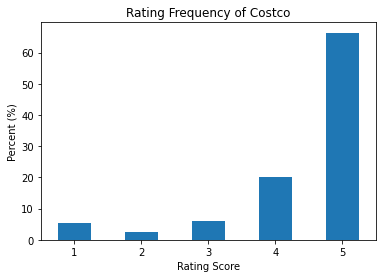

In [33]:
plot1 = costco['star rating'].value_counts(normalize=True).sort_index()
plot1 = plot1 * 100

plot1.index = [1,2,3,4,5]
plot1.plot(kind='bar')
plt.title("Rating Frequency of Costco");
plt.xlabel('Rating Score');
plt.xticks(rotation=0)
plt.ylabel('Percent (%)');

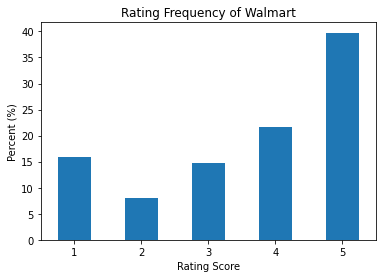

In [34]:
plot1 = walmart['star rating'].value_counts(normalize=True).sort_index()
plot1 = plot1 * 100

plot1.index = [1,2,3,4,5]
plot1.plot(kind='bar')
plt.title("Rating Frequency of Walmart");
plt.xlabel('Rating Score');
plt.xticks(rotation=0)
plt.ylabel('Percent (%)');

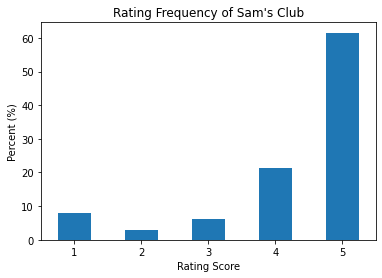

In [36]:
plot1 = samsclub['star rating'].value_counts(normalize=True).sort_index()
plot1 = plot1 * 100

plot1.index = [1,2,3,4,5]
plot1.plot(kind='bar')
plt.title("Rating Frequency of Sam's Club");
plt.xlabel('Rating Score');
plt.xticks(rotation=0)
plt.ylabel('Percent (%)');

## Here we are going to be looking at Topics for each of the Competitors

## ngrams and topics for 5 star reviews

In [34]:
ngrams_costco_5 , topics_5 = ngrams_and_topic_modeling(costco,rating_score=5)

done with ngrams
starting lda...


In [41]:
ngrams_costco_5

,value_count,n-gram
36,49,store clean organized
45,48,staff friendly helpful
21,47,selection great price
4,46,product great price
30,45,product good price
41,44,place shop great
7,43,place buy bulk
1,42,nice place shop
32,41,love shopping costco
34,40,love place great


In [42]:
topics_5

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,great,6135.9,costco,5847.9,good,4578.4
1,place,4554.2,love,5414.4,service,2754.8
2,store,2960.7,best,3269.4,shopping,2244.0
3,staff,2637.7,price,2236.5,nice,2146.7
4,shop,2373.2,need,2001.0,selection,1939.2
5,friendly,2222.7,gas,1757.2,customer,1655.1
6,food,2145.4,item,1693.6,excellent,1607.4
7,quality,1868.4,deal,1555.8,like,1598.2
8,helpful,1849.7,line,1476.2,lot,1413.5
9,product,1825.1,employee,1323.9,busy,1343.5


## ngrams and topics for 4 star reviews

In [37]:
ngrams_costco_4, topics_4 = ngrams_and_topic_modeling(costco,rating_score=4)

done with ngrams
starting lda...


In [43]:
topics_4

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,good,1753.8,costco,1870.0,line,770.7
1,great,1499.4,love,831.7,nice,753.0
2,price,1211.3,parking,749.8,busy,737.6
3,place,825.5,crowded,728.0,clean,682.4
4,selection,704.8,lot,704.4,staff,659.9
5,food,677.7,gas,595.6,service,588.5
6,product,674.3,location,553.5,shop,573.7
7,need,650.3,item,416.0,friendly,504.7
8,store,588.8,better,402.2,deal,493.0
9,shopping,536.0,store,363.8,time,442.9


In [44]:
ngrams_costco_4

,value_count,n-gram
19,49,thing dont like
23,48,stuff good price
16,47,store great price
49,46,store good price
18,45,staff helpful friendly
17,44,staff friendly helpful
46,43,selection great price
22,42,selection good price
43,41,product great price
29,40,product good price


In [38]:
ngrams_costco_3, topics_3 = ngrams_and_topic_modeling(costco,rating_score=3)

done with ngrams
starting lda...


In [45]:
ngrams_costco_3

,value_count,n-gram
38,49,typical big box
8,48,towel toilet paper
11,47,store parking lot
0,46,staff friendly helpful
47,45,selection good price
10,44,sam club bjs
45,43,sam club better
13,42,really like costco
46,41,price bulk item
36,40,pretty standard costco


In [46]:
topics_3

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,store,364.0,good,333.4,costco,436.6
1,dont,215.2,crowded,274.1,need,251.1
2,price,209.0,parking,262.0,item,248.0
3,product,206.3,place,253.9,location,174.7
4,people,203.1,line,248.7,selection,173.0
5,staff,184.8,lot,213.7,better,160.2
6,thing,167.6,food,194.0,busy,137.7
7,great,161.8,long,191.4,gas,132.0
8,membership,158.7,love,150.4,checkout,124.7
9,shopping,151.0,costco,144.4,buy,123.4


In [39]:
ngrams_costco_2, topics_2 = ngrams_and_topic_modeling(costco,rating_score=2)

done with ngrams
starting lda...


In [47]:
ngrams_costco_2

,value_count,n-gram
9,49,worst customer service
35,48,wait 10 minute
39,47,usually enjoy costco
20,46,used love costco
41,45,terrible customer service
0,44,staff friendly helpful
11,43,self checkout line
13,42,sam club way
16,41,sam club dont
15,40,sam club costco


In [48]:
topics_2

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,good,111.6,costco,209.2,store,156.8
1,time,101.6,parking,103.6,line,117.9
2,place,89.7,customer,100.1,people,117.6
3,like,80.6,membership,98.7,dont,107.9
4,food,72.4,price,92.2,crowded,104.6
5,rude,68.0,location,90.5,item,98.9
6,went,57.1,lot,76.8,staff,84.3
7,way,56.5,employee,75.3,long,73.5
8,bad,52.9,great,70.7,cashier,65.2
9,busy,50.3,service,63.1,check,60.2


In [40]:
ngrams_costco_1, topics_1 = ngrams_and_topic_modeling(costco,rating_score=1)

done with ngrams
starting lda...


In [49]:
ngrams_costco_1

,value_count,n-gram
27,49,worst customer service experience
0,48,worst customer service
39,47,worst costco ive
42,46,worst costco experience
49,45,worse customer service
11,44,went customer service
47,43,waited 30 minute
46,42,visa credit card
24,41,terrible customer service
31,40,sam club membership


In [50]:
topics_1

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,rude,224.4,membership,265.0,customer,393.6
1,cashier,187.3,dont,239.4,service,375.7
2,costco,186.2,card,229.5,costco,299.5
3,staff,183.4,line,228.7,employee,231.0
4,worst,173.8,people,205.8,location,162.1
5,experience,170.5,like,173.5,tire,158.0
6,good,147.0,item,140.6,mask,146.3
7,today,146.0,place,130.4,manager,137.5
8,shop,137.6,day,129.5,terrible,115.7
9,store,129.5,food,128.5,store,108.7
